In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import sys
from tensorflow.keras.models import load_model
from barazmoon.twitter import twitter_workload_generator
from statsmodels.tsa.arima.model import ARIMA




2024-02-15 15:47:44.147033: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-15 15:47:44.149152: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-15 15:47:44.190894: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-15 15:47:44.191814: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-15 15:47:44.845661: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

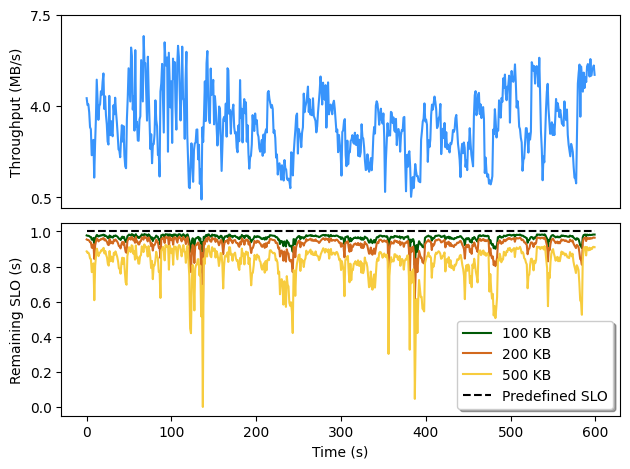

In [3]:
# bursty workload
start = 1296000
duration = 20 * 60  # 20 minutes
workload = twitter_workload_generator(f"{start}-{start + duration}", damping_factor=1)
# len(workload)

colors = ['#005906', 'chocolate', '#f7cc3e', 'plum', '#3894fc']
log_file_path = 'report_bus_0001.log'
bandwidth = []
with open(log_file_path, 'r') as file:
    # Iterate through each line in the file
    for line in file:
        elements = line.split()
        fifth_number = float(elements[4])
        sixth_number = float(elements[5])
        result = int(fifth_number / sixth_number)  # bytes
        bandwidth.append(result)
sla = 1000
time_length = 10 * 60  # 10 minutes
image_size_100 = 100 * 1024  # 100 KB
image_size_200 = 200 * 1024  # 200 KB
image_size_500 = 500 * 1024  # 500 KB
# print(max(bandwidth), min(bandwidth))
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot([x * 1000 / 1024 / 1024 for x in bandwidth], color=colors[-1])
ax1.set_xticks([])
ax1.set_yticks([0.5, 4, 7.5])
ax1.set_ylabel('Throughput (MB/s)')

communication_cost_100 = [image_size_100 / x for x in bandwidth]
dynamic_sla_100 = [int(sla - x) for x in communication_cost_100]
dynamic_sla_100 = dynamic_sla_100[0: time_length]
dynamic_sla_100 = [x / 1000.0 for x in dynamic_sla_100]
ax2.plot(dynamic_sla_100, color=colors[0], label='100 KB')

communication_cost_200 = [image_size_200 / x for x in bandwidth]
dynamic_sla_200 = [int(sla - x) for x in communication_cost_200]
dynamic_sla_200 = dynamic_sla_200[0: time_length]
dynamic_sla_200 = [x / 1000.0 for x in dynamic_sla_200]
ax2.plot(dynamic_sla_200, color=colors[1], label='200 KB')

communication_cost_500 = [image_size_500 / x for x in bandwidth]
dynamic_sla_500 = [int(sla - x) if int(sla - x) > 0 else 0 for x in communication_cost_500]
dynamic_sla_500 = dynamic_sla_500[0: time_length]
dynamic_sla_500 = [x / 1000.0 for x in dynamic_sla_500]
ax2.plot(dynamic_sla_500, color=colors[2], label='500 KB')

ax2.plot([sla / 1000] * time_length, '--', color='black', label='Predefined SLO')

# ax2.set_ylim([500, sla + 10])
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Remaining SLO (s)')
ax2.legend(loc='lower right', fancybox=True, shadow=True)

fig.tight_layout()
plt.show()


In [4]:
import csv

# Example dictionary
slas = {
    "100": dynamic_sla_100,
    "200": dynamic_sla_200,
    "500": dynamic_sla_500
}

# Specify the CSV file path
csv_file_path = 'slas.csv'

# Write the dictionary to a CSV file
with open(csv_file_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    
    # Write header
    writer.writerow(['SLA', 'Values'])
    
    # Write data rows
    for key, values in slas.items():
        writer.writerow([key] + values)


In [5]:
import csv

# Dictionary to store loaded data
slas_loaded = {}

# Path to the CSV file
csv_file_path = 'slas.csv'

# Read data from CSV file and load into dictionary
with open(csv_file_path, 'r', newline='') as csvfile:
    reader = csv.reader(csvfile)
    
    # Skip the header
    next(reader)
    
    # Read data rows
    for row in reader:
        sla = row[0]
        values = [float(value) for value in row[1:]]  # Convert values to floats
        slas_loaded[sla] = values

# Print the loaded dictionary
print(slas_loaded['500'])


[0.886, 0.878, 0.879, 0.869, 0.846, 0.842, 0.768, 0.772, 0.818, 0.608, 0.804, 0.859, 0.902, 0.883, 0.859, 0.877, 0.879, 0.892, 0.889, 0.9, 0.906, 0.874, 0.888, 0.866, 0.851, 0.814, 0.805, 0.888, 0.83, 0.857, 0.834, 0.827, 0.878, 0.867, 0.886, 0.87, 0.855, 0.83, 0.79, 0.785, 0.759, 0.82, 0.85, 0.814, 0.848, 0.769, 0.709, 0.696, 0.86, 0.886, 0.91, 0.898, 0.882, 0.921, 0.917, 0.873, 0.888, 0.839, 0.92, 0.847, 0.855, 0.817, 0.816, 0.859, 0.864, 0.915, 0.902, 0.882, 0.926, 0.913, 0.913, 0.893, 0.857, 0.916, 0.89, 0.853, 0.791, 0.832, 0.728, 0.806, 0.807, 0.832, 0.884, 0.858, 0.848, 0.769, 0.775, 0.621, 0.892, 0.899, 0.912, 0.884, 0.835, 0.924, 0.915, 0.911, 0.916, 0.782, 0.919, 0.902, 0.876, 0.901, 0.81, 0.915, 0.902, 0.913, 0.876, 0.841, 0.912, 0.922, 0.916, 0.892, 0.858, 0.89, 0.922, 0.885, 0.883, 0.821, 0.902, 0.919, 0.832, 0.749, 0.447, 0.42, 0.725, 0.809, 0.742, 0.55, 0.788, 0.809, 0.811, 0.841, 0.842, 0.749, 0.805, 0.516, 0.69, 0.0, 0.846, 0.813, 0.866, 0.901, 0.857, 0.913, 0.919, 0.8

In [6]:
# from barazmoon.slas import slas_workload_generator

# len(slas_workload_generator(image_size=500, sla=1000, length=10000))

In [7]:
__file__ = globals()["_dh"][0]
project_dir = __file__ = globals()["_dh"][0]

sys.path.append(os.path.normpath(os.path.join(project_dir, "..", "..", "..")))

from experiments.utils.slas import make_slas

output = make_slas(image_size=100, sla=1000, length=1000)
output

[977,
 975,
 975,
 973,
 969,
 968,
 953,
 954,
 963,
 921,
 960,
 971,
 980,
 976,
 971,
 975,
 975,
 978,
 977,
 980,
 981,
 974,
 977,
 973,
 970,
 962,
 961,
 977,
 966,
 971,
 966,
 965,
 975,
 973,
 977,
 974,
 971,
 966,
 958,
 957,
 951,
 964,
 970,
 962,
 969,
 953,
 941,
 939,
 972,
 977,
 982,
 979,
 976,
 984,
 983,
 974,
 977,
 967,
 984,
 969,
 971,
 963,
 963,
 971,
 972,
 983,
 980,
 976,
 985,
 982,
 982,
 978,
 971,
 983,
 978,
 970,
 958,
 966,
 945,
 961,
 961,
 966,
 976,
 971,
 969,
 953,
 955,
 924,
 978,
 979,
 982,
 976,
 967,
 984,
 983,
 982,
 983,
 956,
 983,
 980,
 975,
 980,
 962,
 983,
 980,
 982,
 975,
 968,
 982,
 984,
 983,
 978,
 971,
 978,
 984,
 977,
 976,
 964,
 980,
 983,
 966,
 949,
 889,
 884,
 945,
 961,
 948,
 910,
 957,
 961,
 962,
 968,
 968,
 949,
 961,
 903,
 938,
 762,
 969,
 962,
 973,
 980,
 971,
 982,
 983,
 976,
 971,
 970,
 982,
 977,
 978,
 980,
 970,
 977,
 975,
 969,
 960,
 966,
 975,
 974,
 962,
 935,
 960,
 971,
 972,
 971,
 976

In [8]:
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
import math

def batch_cost_latency_model(bc, gamma, delta, epsilon, eta):
    b, c = bc
    return gamma * b / c + delta * b + epsilon / c + eta


def batch_cost_latency_calculation(b, c, gamma, delta, epsilon, eta):
    return int(gamma * b / c + delta * b + epsilon / c + eta)



def algo():
    l_data = [0.045993, 0.028877, 0.018015, 0.012402, 0.012998, 0.012614,
              0.078691, 0.044688, 0.027158, 0.018366, 0.015046, 0.014883,
              0.145413, 0.082432, 0.050079, 0.031439, 0.026703, 0.026107,
              0.287641, 0.166140, 0.087943, 0.057045, 0.046492, 0.042403,
              0.383536, 0.222231, 0.169030, 0.114533, 0.088064, 0.086104]  # latency for eq 2
    for i in range(len(l_data)):
        curr = l_data[i]
        l_data[i] = int(curr * 1000)

    b_data = [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 8, 8, 8, 8, 8, 8, 16, 16, 16, 16, 16, 16]  # batch size for eq 2

    c_data = [1, 2, 4, 8, 16, 32, 1, 2, 4, 8, 16, 32, 1, 2, 4, 8, 16, 32, 1, 2, 4, 8, 16, 32, 1, 2, 4, 8, 16, 32]  # cpu core for eq 2

    params, _ = curve_fit(batch_cost_latency_model, (b_data, c_data), l_data)  # eq 2
    gamma, delta, epsilon, eta = params  # eq 2 parameters
    c_max = 16  # max cpu core allocation
    b_max = 16  # max batch size configuration
    RPS = 100  # workload
    q = [50] * RPS  # calculate this from the user
    cl_max = max(q)  # maximum communication latency
    SLO = 1000  # default SLO

    for c in range(1, c_max + 1):  # iterate over all the cpu cores
        for b in range(1, b_max + 1):  # iterate over all the batch sizes
            l_bc = batch_cost_latency_calculation(b, c, gamma, delta, epsilon, eta)  # calculate latency with the candidate batch and cpu using eq 2
            q_time = 0  # queue time for requests
            better = True  # have we found a configuration?
            for i in range(0, RPS, b):  # iterate over all the requests in the queue
                if l_bc + q_time + cl_max > SLO:  # the current configuration does not satisfy the SLOs
                    better = False
                    break
                q_time += l_bc  # increase queuing time for the next batch of request
            if better:  # if true, we have the least cpu core + the least batch configurations
                return c, b


def fa2_one_model():
    l_data = [0.045993, 0.028877, 0.018015, 0.012402, 0.012998, 0.012614,
              0.078691, 0.044688, 0.027158, 0.018366, 0.015046, 0.014883,
              0.145413, 0.082432, 0.050079, 0.031439, 0.026703, 0.026107,
              0.287641, 0.166140, 0.087943, 0.057045, 0.046492, 0.042403,
              0.383536, 0.222231, 0.169030, 0.114533, 0.088064, 0.086104]  # latency for eq 2
    for i in range(len(l_data)):
        curr = l_data[i]
        l_data[i] = int(curr * 1000)

    b_data = [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 8, 8, 8, 8, 8, 8, 16, 16, 16, 16, 16, 16]  # batch size for eq 2

    c_data = [1, 2, 4, 8, 16, 32, 1, 2, 4, 8, 16, 32, 1, 2, 4, 8, 16, 32, 1, 2, 4, 8, 16, 32, 1, 2, 4, 8, 16, 32]  # cpu core for eq 2

    params, _ = curve_fit(batch_cost_latency_model, (b_data, c_data), l_data)  # eq 2
    gamma, delta, epsilon, eta = params  # eq 2 parameters
    b_max = 16  # max batch size configuration
    RPS = 100  # workload
    q = [50] * RPS  # calculate this from the user
    cl_max = max(q)  # maximum communication latency
    SLO = 1000  # default SLO
    instance_number = 100  # result number of instances
    best_batch = 0  # result batch size
    for b in range(1, b_max + 1):  # iterate over all the batch sizes
        l_bc = batch_cost_latency_calculation(b, 1, gamma, delta, epsilon, eta)  # calculate latency with the candidate batch and cpu using eq 2
        q_time = 0  # queue time for requests
        curr_instance = math.ceil(RPS / (int(1000 / l_bc) * b))  # current instance nubmer
        for i in range(0, RPS, b):  # iterate over all the requests in the queue
            q_time += l_bc  # increase queuing time for the next batch of request
        if l_bc + q_time + cl_max < SLO and curr_instance < instance_number:  # the current configuration not satisfy the SLOs and there is a smaller instance number
            instance_number = curr_instance
            best_batch = b
    return instance_number, best_batch


if __name__ == "__main__":
    c_dyna, b_dyna = algo()
    print(f'optimal cpu allocation: {c_dyna} optimal batch configuration: {b_dyna}')
    n_fa2, b_fa2 = fa2_one_model()
    print(f'optimal instance number: {n_fa2} optimal batch configuration: {b_fa2}')

optimal cpu allocation: 5 optimal batch configuration: 10
optimal instance number: 3 optimal batch configuration: 12
